# Projet 08 : Communiquer des résultats
# Partie 3 : Modélisation - Régression logistique pour estimer si une configuration appartient au top_cluster

---

## <font color=blue>Sommaire</font>

[3. Modélisation](#3_0)   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5. Régression logistique pour estimer si une configuration appartient au top_cluster](#3_5)  

---
**Importation des librairies**

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
#import warnings
#warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as plc
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import model_selection
from statsmodels.stats.outliers_influence import variance_inflation_factor

import modules_perso.sf_graphiques as sfg
import modules_perso.sf_classification_acp as sfca
import modules_perso.sf_modeles_anova as sfma

<a id='3_0'></a>

---
## <font color=blue>Mission 3 : Modélisation</font>

In [4]:
echant_alea_data21 = pd.read_csv("echantillon_alea_data21.csv", parse_dates=["dateref"])
echant_alea_data21.head()

,contract_id,dateref,category_name,somme_signaux,variation_21_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT2,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil
0,9,2015-07-22,LTIR,165,4.013552e-01,8,False,69,31,65,...,-8,-2,25,25,25,-10,0,0,True,True
1,91,2009-06-29,Metals,30,5.976307e-02,2,False,7,23,0,...,17,14,-25,-25,-25,25,25,25,True,False
2,32,2009-08-14,STIR,416,5.403889e-01,0,True,150,116,150,...,23,20,25,25,25,25,25,25,True,True
3,6,2010-02-26,Currencies,67,-4.207197e-01,6,False,59,-6,14,...,-4,-2,25,25,11,-25,-25,3,True,True
4,37,2011-08-18,STIR,432,-3.030987e-13,1,False,150,132,150,...,21,17,25,25,25,25,25,25,False,False


In [5]:
echant_alea_data42 = pd.read_csv("echantillon_alea_data42.csv", parse_dates=["dateref"])
echant_alea_data42.head()

,contract_id,dateref,category_name,somme_signaux,variation_42_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT2,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil
0,13,2013-12-26,LTIR,136,0.492840,6,False,29,39,68,...,18,11,-3,-4,0,25,25,25,False,True
1,12,1991-05-03,LTIR,0,-0.069842,0,False,0,0,0,...,0,0,0,0,0,0,0,0,True,False
2,15,1991-01-04,LTIR,0,-0.144532,0,False,0,0,0,...,0,0,0,0,0,0,0,0,True,False
3,23,2001-06-22,Energy,-200,-0.368365,9,False,-54,-99,-47,...,-25,-25,18,7,3,-25,-25,-25,True,True
4,26,2006-06-15,Energy,343,0.362887,8,False,146,59,138,...,14,15,25,25,25,25,25,13,True,True


In [6]:
echant_alea_data64 = pd.read_csv("echantillon_alea_data64.csv", parse_dates=["dateref"])
echant_alea_data64.head()

,contract_id,dateref,category_name,somme_signaux,variation_64_standard,cluster,top_cluster,BRO,FOT,MOM,...,FOT-MT2,FOT-MT3,MOM-LT1,MOM-LT2,MOM-LT3,MOM-MT1,MOM-MT2,MOM-MT3,tendance_cluster,tendance_seuil
0,44,2002-05-16,Index,-59,-0.655845,8,False,0,-20,-39,...,2,2,-25,-25,-25,25,-2,13,False,True
1,25,2009-03-31,Energy,-380,0.694890,9,False,-150,-109,-121,...,-20,-25,-25,-14,-7,-25,-25,-25,True,True
2,59,1990-06-11,Index,0,-0.621847,8,False,0,0,0,...,0,0,0,0,0,0,0,0,False,True
3,25,1993-05-11,Energy,18,-0.861281,8,False,12,30,-24,...,17,10,-25,-25,-25,25,25,1,False,True
4,33,1997-09-15,STIR,424,0.346597,0,False,150,124,150,...,25,24,25,25,25,25,25,25,True,False


<a id='3_5'></a>

## 3.5. Régression logistique pour estimer si une configuration appartient au top_cluster

L'analyse menée auparavant a montré que la configuration qui a le plus de probabilité d'appartenir au top_cluster correspond à :
- une somme des signaux comrise entre 100 et 300 (ou 125 et 300) ;
- ou un indicateur FOT compris entre 40 et 75 ; 
- ou une somme des indicateurs BRO et MOM comprise entre 85 et 225.  
  
Ces conditions ne sont valables que pour les variations à 2 ou 3 mois et peuvent être testées indépendamment ou ensemble.

In [7]:
logistic_alea42 = echant_alea_data42[["top_cluster","somme_signaux","BRO","FOT","MOM"]].copy()
logistic_alea42.top_cluster = logistic_alea42.top_cluster.astype('int')
logistic_alea42["trigger_somme"] = (logistic_alea42.somme_signaux >= 100) & (logistic_alea42.somme_signaux <= 300)
logistic_alea42["trigger_FOT"] = (logistic_alea42.FOT >= 40) & (logistic_alea42.FOT <= 75)
logistic_alea42["trigger_BROMOM"] = (logistic_alea42.BRO + logistic_alea42.MOM >= 85) & \
                                    (logistic_alea42.BRO + logistic_alea42.MOM <= 225)
logistic_alea42.trigger_somme = logistic_alea42.trigger_somme.astype('int')
logistic_alea42.trigger_FOT = logistic_alea42.trigger_FOT.astype('int')
logistic_alea42.trigger_BROMOM = logistic_alea42.trigger_BROMOM.astype('int')
logistic_alea42.head()

,top_cluster,somme_signaux,BRO,FOT,MOM,trigger_somme,trigger_FOT,trigger_BROMOM
0,0,136,29,39,68,1,0,1
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0
3,0,-200,-54,-99,-47,0,0,0
4,0,343,146,59,138,0,1,0


In [8]:
logistic_alea64 = echant_alea_data64[["top_cluster","somme_signaux","BRO","FOT","MOM"]].copy()
logistic_alea64.top_cluster = logistic_alea64.top_cluster.astype('int')
logistic_alea64["trigger_somme"] = (logistic_alea64.somme_signaux >= 100) & (logistic_alea64.somme_signaux <= 300)
logistic_alea64["trigger_FOT"] = (logistic_alea64.FOT >= 40) & (logistic_alea64.FOT <= 75)
logistic_alea64["trigger_BROMOM"] = (logistic_alea64.BRO + logistic_alea64.MOM >= 85) & \
                                    (logistic_alea64.BRO + logistic_alea64.MOM <= 225)
logistic_alea64.trigger_somme = logistic_alea64.trigger_somme.astype('int')
logistic_alea64.trigger_FOT = logistic_alea64.trigger_FOT.astype('int')
logistic_alea64.trigger_BROMOM = logistic_alea64.trigger_BROMOM.astype('int')
logistic_alea64.head()

,top_cluster,somme_signaux,BRO,FOT,MOM,trigger_somme,trigger_FOT,trigger_BROMOM
0,0,-59,0,-20,-39,0,0,0
1,0,-380,-150,-109,-121,0,0,0
2,0,0,0,0,0,0,0,0
3,0,18,12,30,-24,0,0,0
4,0,424,150,124,150,0,0,0


### 3.5.1. Modélisation basée sur la somme globale des signaux (trigger)

**Variation à 2 mois**

In [9]:
data_model = logistic_alea42[["top_cluster","trigger_somme"]].copy()
len(data_model)

71679

In [10]:
anova = smf.ols(formula="top_cluster ~ trigger_somme", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     837.7
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          3.93e-183
Time:                        09:32:23   Log-Likelihood:                 4153.5
No. Observations:               71679   AIC:                            -8303.
Df Residuals:                   71677   BIC:                            -8285.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0436      0.001     45.854      0.000       0.042       0.046
trigger_somme     0.0621      0.002     28.943      0.000       0.058       0.066
==============================================================================
Omnibus:                    54218.372   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           653836.493
Skew:                           3.803   Prob(JB):                         0.00
Kurtosis:                      15.692   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Variation à 3 mois**

In [11]:
data_model = logistic_alea64[["top_cluster","trigger_somme"]].copy()
len(data_model)

71455

In [12]:
anova = smf.ols(formula="top_cluster ~ trigger_somme", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1059.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          1.15e-230
Time:                        09:32:23   Log-Likelihood:                 1600.5
No. Observations:               71455   AIC:                            -3197.
Df Residuals:                   71453   BIC:                            -3179.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0462      0.001     46.748      0.000       0.044       0.048
trigger_somme     0.0724      0.002     32.547      0.000       0.068       0.077
==============================================================================
Omnibus:                    51442.437   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           535941.306
Skew:                           3.611   Prob(JB):                         0.00
Kurtosis:                      14.308   Cond. No.                         2.63
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La somme des signaux ne permet pas de détecter les configurations du top_cluster.

### 3.5.2. Modélisation basée sur la somme des signaux pour l'indicateur FOT (trigger)

**Variation à 2 mois**

In [13]:
data_model = logistic_alea42[["top_cluster","trigger_FOT"]].copy()
len(data_model)

71679

In [14]:
anova = smf.ols(formula="top_cluster ~ trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     340.1
Date:                Tue, 26 Nov 2019   Prob (F-statistic):           8.97e-76
Time:                        09:32:23   Log-Likelihood:                 3906.8
No. Observations:               71679   AIC:                            -7810.
Df Residuals:                   71677   BIC:                            -7791.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0492      0.001     52.893      0.000       0.047       0.051
trigger_FOT     0.0439      0.002     18.443      0.000       0.039       0.049
==============================================================================
Omnibus:                    54655.509   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           669181.294
Skew:                           3.841   Prob(JB):                         0.00
Kurtosis:                      15.847   Cond. No.                         2.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Variation à 3 mois**

In [15]:
data_model = logistic_alea64[["top_cluster","trigger_FOT"]].copy()
len(data_model)

71455

In [16]:
anova = smf.ols(formula="top_cluster ~ trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     474.2
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          8.45e-105
Time:                        09:32:23   Log-Likelihood:                 1311.1
No. Observations:               71455   AIC:                            -2618.
Df Residuals:                   71453   BIC:                            -2600.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0522      0.001     54.067      0.000       0.050       0.054
trigger_FOT     0.0537      0.002     21.777      0.000       0.049       0.059
==============================================================================
Omnibus:                    51941.796   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           550480.733
Skew:                           3.653   Prob(JB):                         0.00
Kurtosis:                      14.468   Cond. No.                         2.85
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Pas d'amélioration de la modélisation en ne prenant que le trigger_FOT.

### 3.5.3. Modélisation basée sur la somme des signaux pour les indicateurs BRO et MOM

**Variation à 2 mois**

In [17]:
data_model = logistic_alea42[["top_cluster","trigger_BROMOM"]].copy()
len(data_model)

71679

In [18]:
anova = smf.ols(formula="top_cluster ~ trigger_BROMOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     667.6
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          1.57e-146
Time:                        09:32:23   Log-Likelihood:                 4069.4
No. Observations:               71679   AIC:                            -8135.
Df Residuals:                   71677   BIC:                            -8116.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0454      0.001     47.945      0.000       0.044       0.047
trigger_BROMOM     0.0568      0.002     25.838      0.000       0.052       0.061
==============================================================================
Omnibus:                    54368.033   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           659053.719
Skew:                           3.816   Prob(JB):                         0.00
Kurtosis:                      15.745   Cond. No.                         2.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Variation à 3 mois**

In [19]:
data_model = logistic_alea64[["top_cluster","trigger_BROMOM"]].copy()
len(data_model)

71455

In [20]:
anova = smf.ols(formula="top_cluster ~ trigger_BROMOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     840.7
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          8.82e-184
Time:                        09:32:23   Log-Likelihood:                 1492.6
No. Observations:               71455   AIC:                            -2981.
Df Residuals:                   71453   BIC:                            -2963.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.0482      0.001     49.080      0.000       0.046       0.050
trigger_BROMOM     0.0661      0.002     28.995      0.000       0.062       0.071
==============================================================================
Omnibus:                    51629.059   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           541329.412
Skew:                           3.626   Prob(JB):                         0.00
Kurtosis:                      14.367   Cond. No.                         2.68
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Encore une fois, la modélisation n'est pas performante.

Je teste la modélisation en prenant les 3 triggers comme exogènes, avec les interractions.

### 3.5.4. Modélisation basée sur les différents triggers avec les interactions

**Variation à 2 mois**

In [21]:
data_model = logistic_alea42[["top_cluster","trigger_somme","trigger_FOT","trigger_BROMOM"]].copy()
len(data_model)

71679

In [22]:
anova = smf.ols(formula="top_cluster ~ trigger_somme * trigger_FOT * trigger_BROMOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     151.3
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          1.31e-191
Time:                        09:32:23   Log-Likelihood:                 4188.2
No. Observations:               71679   AIC:                            -8362.
Df Residuals:                   71672   BIC:                            -8298.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0413      0.001     41.163      0.000       0.039       0.043
trigger_somme                                0.0596      0.007      8.148      0.000       0.045       0.074
trigger_FOT                                  0.0209      0.004      5.627      0.000       0.014       0.028
trigger_somme:trigger_FOT                   -0.0181      0.010     -1.805      0.071      -0.038       0.002
trigger_BROMOM                               0.0312      0.006      5.481      0.000       0.020       0.042
trigger_somme:trigger_BROMOM                -0.0319      0.010     -3.300      0.001      -0.051      -0.013
trigger_FOT:trigger_BROMOM                   0.0052      0.005      1.024      0.306      -0.005       0.015
trigger_somme:trigger_FOT:trigger_BROMOM     0.0052      0.005      1.024      0.306      -0.005       0.015
==============================================================================
Omnibus:                    54151.655   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           651391.197
Skew:                           3.797   Prob(JB):                         0.00
Kurtosis:                      15.666   Cond. No.                     6.73e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.99e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

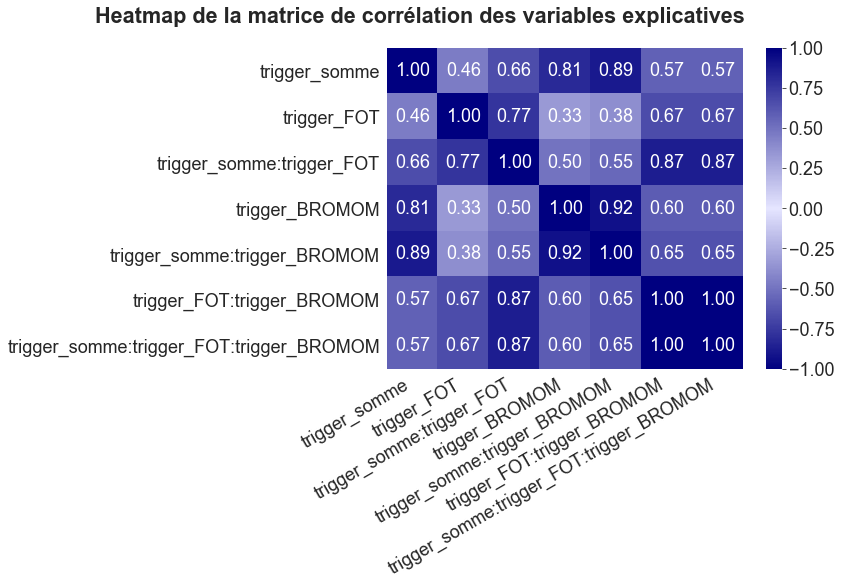

In [23]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [24]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\outliers_influence.py:181: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF
trigger_somme,11.662736
trigger_FOT,2.456758
trigger_somme:trigger_FOT,12.015539
trigger_BROMOM,6.743920
trigger_somme:trigger_BROMOM,17.448579
trigger_FOT:trigger_BROMOM,inf
trigger_somme:trigger_FOT:trigger_BROMOM,inf


L'analyse de la multicolinéarité simple montre qu'il y a de nombreux problèmes de colinéarité simple et multiple. Comme l'interaction globale n'est pas significative, je l'enlève pour y voir plus claire.

In [25]:
anova = smf.ols(formula="top_cluster ~ trigger_somme * trigger_FOT * trigger_BROMOM - trigger_somme:trigger_FOT:trigger_BROMOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     151.3
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          1.31e-191
Time:                        09:32:24   Log-Likelihood:                 4188.2
No. Observations:               71679   AIC:                            -8362.
Df Residuals:                   71672   BIC:                            -8298.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0413      0.001     41.163      0.000       0.039       0.043
trigger_somme                    0.0596      0.007      8.148      0.000       0.045       0.074
trigger_FOT                      0.0209      0.004      5.627      0.000       0.014       0.028
trigger_somme:trigger_FOT       -0.0181      0.010     -1.805      0.071      -0.038       0.002
trigger_BROMOM                   0.0312      0.006      5.481      0.000       0.020       0.042
trigger_somme:trigger_BROMOM    -0.0319      0.010     -3.300      0.001      -0.051      -0.013
trigger_FOT:trigger_BROMOM       0.0105      0.010      1.024      0.306      -0.010       0.031
==============================================================================
Omnibus:                    54151.655   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           651391.197
Skew:                           3.797   Prob(JB):                         0.00
Kurtosis:                      15.666   Cond. No.                         21.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
trigger_somme,5.801507,1.0,111.358676,5.159820e-26,0.001550,1.535782e-03
trigger_FOT,1.947766,1.0,37.386948,9.736663e-10,0.000520,5.063478e-04
trigger_somme:trigger_FOT,0.169677,1.0,3.256920,7.112679e-02,0.000045,3.137414e-05
trigger_BROMOM,1.027568,1.0,19.723946,8.960677e-06,0.000274,2.605390e-04
trigger_somme:trigger_BROMOM,0.567484,1.0,10.892733,9.658939e-04,0.000152,1.376386e-04
trigger_FOT:trigger_BROMOM,0.054612,1.0,1.048269,3.059095e-01,0.000015,6.372494e-07
Residual,3733.930871,71672.0,NaN,NaN,NaN,NaN
total,3743.499485,71678.0,NaN,NaN,NaN,NaN


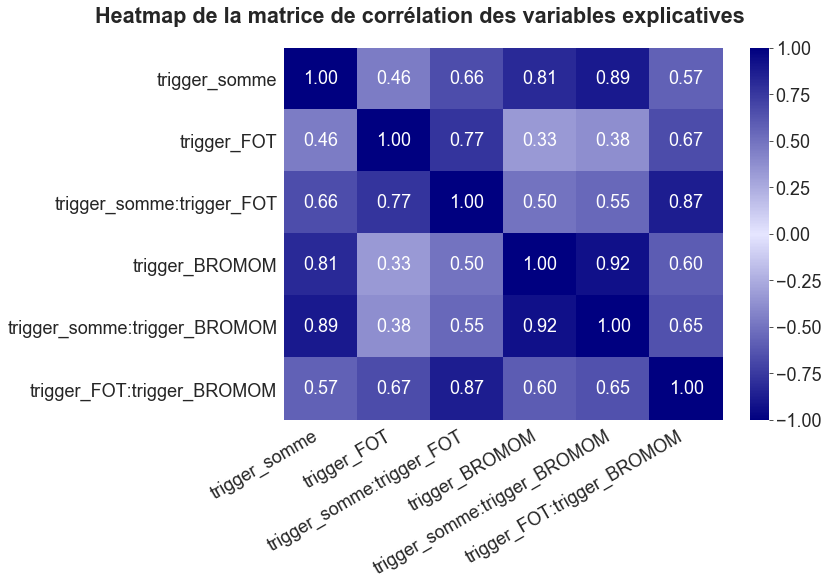

In [27]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

A la vue de cette matrice de corrélation et des p-values, il faut choisir entre :
- trigger_somme, trigger_BROMOM et leur interaction ;
- trigger_somme:trigger_FOT et trigger_FOT:trigger_BROMOM.
  
Idéalement, il faudrait choisir trigger_somme et trigger_FOT:trigger_BROMOM.
Mais il semble mieux de conserver soit trigger_somme et trigger_FOT et leur interaction, ou trigger_BROMOM et trigger_FOT et leur interaction.

In [28]:
anova = smf.ols(formula="top_cluster ~ trigger_somme + trigger_FOT + trigger_FOT:trigger_BROMOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     290.8
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          1.20e-187
Time:                        09:32:25   Log-Likelihood:                 4170.7
No. Observations:               71679   AIC:                            -8333.
Df Residuals:                   71675   BIC:                            -8297.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0425      0.001     43.465      0.000       0.041       0.044
trigger_somme                  0.0557      0.003     21.105      0.000       0.050       0.061
trigger_FOT                    0.0158      0.003      4.915      0.000       0.010       0.022
trigger_FOT:trigger_BROMOM    -0.0005      0.005     -0.098      0.922      -0.010       0.009
==============================================================================
Omnibus:                    54187.247   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           652753.419
Skew:                           3.800   Prob(JB):                         0.00
Kurtosis:                      15.681   Cond. No.                         6.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
anova = smf.ols(formula="top_cluster ~ trigger_somme + trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     436.2
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          5.11e-189
Time:                        09:32:25   Log-Likelihood:                 4170.7
No. Observations:               71679   AIC:                            -8335.
Df Residuals:                   71676   BIC:                            -8308.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0425      0.001     43.848      0.000       0.041       0.044
trigger_somme     0.0556      0.002     23.016      0.000       0.051       0.060
trigger_FOT       0.0156      0.003      5.856      0.000       0.010       0.021
==============================================================================
Omnibus:                    54187.342   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           652759.371
Skew:                           3.800   Prob(JB):                         0.00
Kurtosis:                      15.681   Cond. No.                         3.75
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
anova = smf.ols(formula="top_cluster ~ trigger_somme * trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     291.7
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          3.00e-188
Time:                        09:32:25   Log-Likelihood:                 4172.1
No. Observations:               71679   AIC:                            -8336.
Df Residuals:                   71675   BIC:                            -8299.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0422      0.001     42.786      0.000       0.040       0.044
trigger_somme                 0.0581      0.003     20.344      0.000       0.053       0.064
trigger_FOT                   0.0199      0.004      5.372      0.000       0.013       0.027
trigger_somme:trigger_FOT    -0.0089      0.005     -1.669      0.095      -0.019       0.002
==============================================================================
Omnibus:                    54183.295   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           652563.592
Skew:                           3.800   Prob(JB):                         0.00
Kurtosis:                      15.678   Cond. No.                         7.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
anova = smf.ols(formula="top_cluster ~ trigger_BROMOM * trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     261.4
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          9.53e-169
Time:                        09:32:25   Log-Likelihood:                 4127.1
No. Observations:               71679   AIC:                            -8246.
Df Residuals:                   71675   BIC:                            -8209.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0424      0.001     42.646      0.000       0.040       0.044
trigger_BROMOM                 0.0521      0.003     18.915      0.000       0.047       0.057
trigger_FOT                    0.0310      0.003      9.658      0.000       0.025       0.037
trigger_BROMOM:trigger_FOT    -0.0120      0.005     -2.317      0.020      -0.022      -0.002
==============================================================================
Omnibus:                    54260.476   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           655166.612
Skew:                           3.807   Prob(JB):                         0.00
Kurtosis:                      15.705   Cond. No.                         7.08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
trigger_BROMOM,1.570568
trigger_FOT,1.835674
trigger_BROMOM:trigger_FOT,2.532304


Encore une fois, la modélisation de l'appartenance au top_cluster n'est pas concluante.

**Variation à 3 mois**

In [33]:
data_model = logistic_alea64[["top_cluster","trigger_somme","trigger_FOT","trigger_BROMOM"]].copy()
len(data_model)

71455

In [34]:
anova = smf.ols(formula="top_cluster ~ trigger_somme * trigger_FOT * trigger_BROMOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     191.6
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          3.63e-243
Time:                        09:32:25   Log-Likelihood:                 1645.0
No. Observations:               71455   AIC:                            -3276.
Df Residuals:                   71448   BIC:                            -3212.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                    0.0437      0.001     41.962      0.000       0.042       0.046
trigger_somme                                0.0496      0.008      6.314      0.000       0.034       0.065
trigger_FOT                                  0.0276      0.004      7.200      0.000       0.020       0.035
trigger_somme:trigger_FOT                   -0.0084      0.011     -0.798      0.425      -0.029       0.012
trigger_BROMOM                               0.0195      0.006      3.242      0.001       0.008       0.031
trigger_somme:trigger_BROMOM                 0.0007      0.010      0.070      0.945      -0.019       0.021
trigger_FOT:trigger_BROMOM                  -0.0009      0.005     -0.167      0.868      -0.011       0.010
trigger_somme:trigger_FOT:trigger_BROMOM    -0.0009      0.005     -0.167      0.868      -0.011       0.010
==============================================================================
Omnibus:                    51362.600   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           533589.581
Skew:                           3.604   Prob(JB):                         0.00
Kurtosis:                      14.281   Cond. No.                     9.91e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.16e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [35]:
anova = smf.ols(formula="top_cluster ~ trigger_somme * trigger_FOT * trigger_BROMOM - trigger_somme:trigger_FOT:trigger_BROMOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     191.6
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          3.63e-243
Time:                        09:32:25   Log-Likelihood:                 1645.0
No. Observations:               71455   AIC:                            -3276.
Df Residuals:                   71448   BIC:                            -3212.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                        0.0437      0.001     41.962      0.000       0.042       0.046
trigger_somme                    0.0496      0.008      6.314      0.000       0.034       0.065
trigger_FOT                      0.0276      0.004      7.200      0.000       0.020       0.035
trigger_somme:trigger_FOT       -0.0084      0.011     -0.798      0.425      -0.029       0.012
trigger_BROMOM                   0.0195      0.006      3.242      0.001       0.008       0.031
trigger_somme:trigger_BROMOM     0.0007      0.010      0.070      0.945      -0.019       0.021
trigger_FOT:trigger_BROMOM      -0.0018      0.011     -0.167      0.868      -0.023       0.019
==============================================================================
Omnibus:                    51362.600   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           533589.581
Skew:                           3.604   Prob(JB):                         0.00
Kurtosis:                      14.281   Cond. No.                         22.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

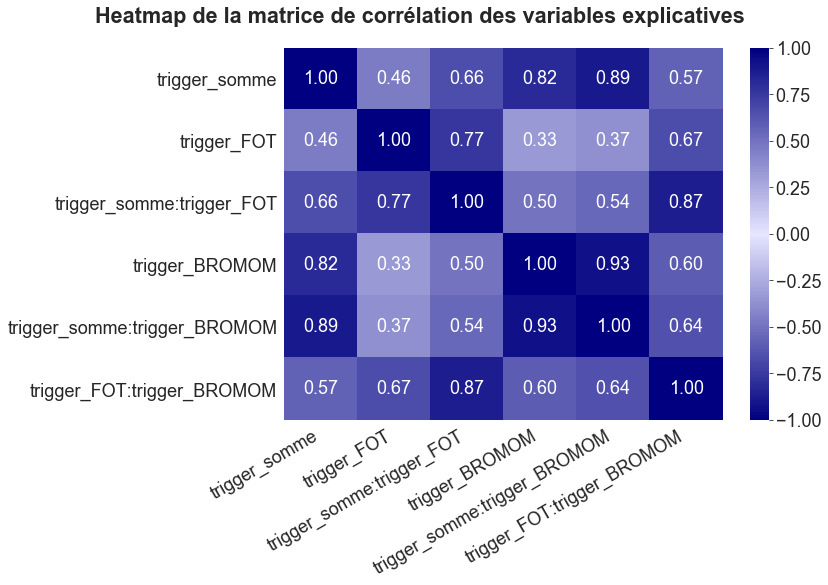

In [36]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [37]:
anova = smf.ols(formula="top_cluster ~ trigger_somme * trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     375.2
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          7.59e-242
Time:                        09:32:26   Log-Likelihood:                 1633.2
No. Observations:               71455   AIC:                            -3258.
Df Residuals:                   71451   BIC:                            -3222.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.0443      0.001     43.172      0.000       0.042       0.046
trigger_somme                 0.0666      0.003     22.494      0.000       0.061       0.072
trigger_FOT                   0.0270      0.004      7.054      0.000       0.020       0.035
trigger_somme:trigger_FOT    -0.0112      0.006     -2.025      0.043      -0.022      -0.000
==============================================================================
Omnibus:                    51382.084   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           534129.853
Skew:                           3.605   Prob(JB):                         0.00
Kurtosis:                      14.287   Cond. No.                         7.61
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
anova = smf.ols(formula="top_cluster ~ trigger_BROMOM * trigger_FOT", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     338.8
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          1.87e-218
Time:                        09:32:26   Log-Likelihood:                 1579.3
No. Observations:               71455   AIC:                            -3151.
Df Residuals:                   71451   BIC:                            -3114.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0445      0.001     43.140      0.000       0.043       0.047
trigger_BROMOM                 0.0587      0.003     20.592      0.000       0.053       0.064
trigger_FOT                    0.0379      0.003     11.424      0.000       0.031       0.044
trigger_BROMOM:trigger_FOT    -0.0104      0.005     -1.940      0.052      -0.021       0.000
==============================================================================
Omnibus:                    51473.891   Durbin-Watson:                   1.988
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           536724.626
Skew:                           3.613   Prob(JB):                         0.00
Kurtosis:                      14.316   Cond. No.                         7.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

La dernière solution pour modéliser l'appartenance au top_cluster est de tenter une régression logistique basée sur les sommes de signaux plutôt que sur les triggers.

### 3.5.5. Modélisation basée sur la somme globale des signaux (nombre)

**Variation à 2 mois**

In [39]:
data_model = logistic_alea42[["top_cluster","somme_signaux"]].copy()
len(data_model)

71679

In [40]:
anova = smf.ols(formula="top_cluster ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     1086.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          2.10e-236
Time:                        09:32:36   Log-Likelihood:                 4276.1
No. Observations:               71679   AIC:                            -8548.
Df Residuals:                   71677   BIC:                            -8530.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0453      0.001     49.866      0.000       0.044       0.047
somme_signaux     0.0001   3.15e-06     32.955      0.000    9.77e-05       0.000
==============================================================================
Omnibus:                    53857.060   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           637998.290
Skew:                           3.774   Prob(JB):                         0.00
Kurtosis:                      15.515   Cond. No.                         308.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Variation à 3 mois**

In [41]:
data_model = logistic_alea64[["top_cluster","somme_signaux"]].copy()
len(data_model)

71455

In [42]:
anova = smf.ols(formula="top_cluster ~ somme_signaux", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1285.
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          7.91e-279
Time:                        09:32:56   Log-Likelihood:                 1711.3
No. Observations:               71455   AIC:                            -3419.
Df Residuals:                   71453   BIC:                            -3400.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.0485      0.001     51.351      0.000       0.047       0.050
somme_signaux     0.0001   3.28e-06     35.840      0.000       0.000       0.000
==============================================================================
Omnibus:                    51062.311   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           521404.847
Skew:                           3.582   Prob(JB):                         0.00
Kurtosis:                      14.126   Cond. No.                         308.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 3.5.6. Modélisation basée sur la somme des signaux par indicateur (nombre)

**Variation à 2 mois**

In [43]:
data_model = logistic_alea42[["top_cluster","BRO","FOT","MOM"]].copy()
len(data_model)

71679

In [44]:
anova = smf.ols(formula="top_cluster ~ BRO * FOT * MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     274.1
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        09:34:43   Log-Likelihood:                 4683.8
No. Observations:               71679   AIC:                            -9352.
Df Residuals:                   71671   BIC:                            -9278.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0535      0.001     39.122      0.000       0.051       0.056
BRO             0.0002    2.7e-05      6.639      0.000       0.000       0.000
FOT             0.0006   3.55e-05     16.749      0.000       0.001       0.001
BRO:FOT      1.027e-06   4.32e-07      2.376      0.018     1.8e-07    1.87e-06
MOM             0.0002   2.92e-05      5.523      0.000       0.000       0.000
BRO:MOM     -2.306e-06   2.41e-07     -9.556      0.000   -2.78e-06   -1.83e-06
FOT:MOM      9.002e-07   4.54e-07      1.984      0.047    1.08e-08    1.79e-06
BRO:FOT:MOM -3.592e-08   1.69e-09    -21.220      0.000   -3.92e-08   -3.26e-08
==============================================================================
Omnibus:                    53055.533   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           609013.896
Skew:                           3.707   Prob(JB):                         0.00
Kurtosis:                      15.204   Cond. No.                     2.45e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

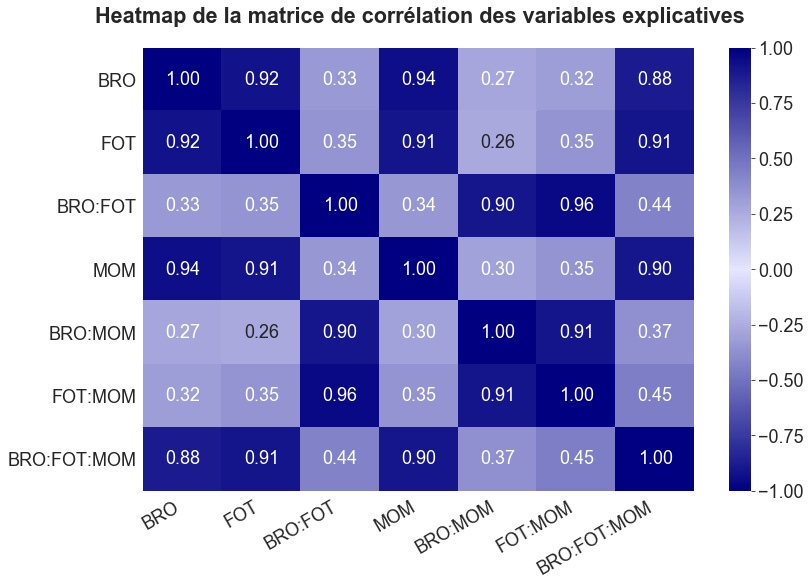

In [45]:
interdata = pd.DataFrame(anova.model.exog, columns=anova.model.exog_names)
variables = anova.model.exog_names.copy()
variables.remove('Intercept')
matrice_correl = np.corrcoef(interdata[variables], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=variables, rotation=0)
mygraph.set_axe('x', tick_labels=variables, rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
#plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [46]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
BRO,1.057863,1.0,20.587914,5.704685e-06,0.000285,0.000271
FOT,4.847550,1.0,94.342006,2.739993e-22,0.001304,0.001290
BRO:FOT,0.226103,1.0,4.400361,3.593481e-02,0.000061,0.000047
MOM,0.448472,1.0,8.728073,3.134493e-03,0.000121,0.000107
BRO:MOM,5.119125,1.0,99.627351,1.905522e-23,0.001377,0.001363
FOT:MOM,0.013122,1.0,0.255384,6.133106e-01,0.000004,-0.000010
BRO:FOT:MOM,23.136976,1.0,450.287031,1.267314e-99,0.006224,0.006210
Residual,3682.651501,71671.0,NaN,NaN,NaN,NaN
total,3717.500712,71678.0,NaN,NaN,NaN,NaN


In [47]:
anova = smf.ols(formula="top_cluster ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     703.0
Date:                Tue, 26 Nov 2019   Prob (F-statistic):          4.61e-303
Time:                        09:36:58   Log-Likelihood:                 4433.3
No. Observations:               71679   AIC:                            -8861.
Df Residuals:                   71676   BIC:                            -8833.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0596      0.001     45.473      0.000       0.057       0.062
FOT            0.0004   1.18e-05     36.790      0.000       0.000       0.000
BRO:MOM    -1.593e-06   9.53e-08    -16.707      0.000   -1.78e-06   -1.41e-06
==============================================================================
Omnibus:                    53530.218   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           624949.570
Skew:                           3.748   Prob(JB):                         0.00
Kurtosis:                      15.372   Cond. No.                     2.20e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Variation à 3 mois**

In [50]:
data_model = logistic_alea64[["top_cluster","BRO","FOT","MOM"]].copy()
len(data_model)

71455

In [51]:
anova = smf.ols(formula="top_cluster ~ FOT + BRO:MOM", data=data_model).fit()
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            top_cluster   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     802.2
Date:                Tue, 26 Nov 2019   Prob (F-statistic):               0.00
Time:                        09:37:44   Log-Likelihood:                 1868.1
No. Observations:               71455   AIC:                            -3730.
Df Residuals:                   71452   BIC:                            -3703.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0626      0.001     46.049      0.000       0.060       0.065
FOT            0.0005   1.23e-05     39.647      0.000       0.000       0.001
BRO:MOM    -1.607e-06   9.93e-08    -16.185      0.000    -1.8e-06   -1.41e-06
==============================================================================
Omnibus:                    50737.705   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           510472.622
Skew:                           3.557   Prob(JB):                         0.00
Kurtosis:                      13.993   Cond. No.                     2.18e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.18e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Aucune modélisation intéressante de l'appartenance au top_cluster.